In [1]:
# -*- coding: utf-8 -*-

import requests, json, re, os, random, time, math
from PIL import Image
from io import BytesIO

x_pi = 3.14159265358979324 * 3000.0 / 180.0
pi = 3.1415926535897932384626 # π
a = 6378245.0 # 长半轴
ee = 0.00669342162296594323 # 扁率
#百度墨卡托投影纠正矩阵
LLBAND =[75, 60, 45, 30, 15, 0]
LL2MC = [[-0.0015702102444, 111320.7020616939, 1704480524535203, -10338987376042340, 26112667856603880, -35149669176653700, 26595700718403920, -10725012454188240, 1800819912950474, 82.5],
         [0.0008277824516172526, 111320.7020463578, 647795574.6671607, -4082003173.641316, 10774905663.51142, -15171875531.51559, 12053065338.62167, -5124939663.577472, 913311935.9512032, 67.5],
         [0.00337398766765, 111320.7020202162, 4481351.045890365, -23393751.19931662, 79682215.47186455, -115964993.2797253, 97236711.15602145, -43661946.33752821, 8477230.501135234, 52.5],
         [0.00220636496208, 111320.7020209128, 51751.86112841131, 3796837.749470245, 992013.7397791013, -1221952.21711287, 1340652.697009075, -620943.6990984312, 144416.9293806241, 37.5],
         [-0.0003441963504368392, 111320.7020576856, 278.2353980772752, 2485758.690035394, 6070.750963243378, 54821.18345352118, 9540.606633304236, -2710.55326746645, 1405.483844121726, 22.5],
         [-0.0003218135878613132, 111320.7020701615, 0.00369383431289, 823725.6402795718, 0.46104986909093, 2351.343141331292, 1.58060784298199, 8.77738589078284, 0.37238884252424, 7.45]]
# 百度墨卡托转回到百度经纬度纠正矩阵
MCBAND = [12890594.86, 8362377.87, 5591021, 3481989.83, 1678043.12, 0]
MC2LL = [[1.410526172116255e-8, 0.00000898305509648872, -1.9939833816331, 200.9824383106796, -187.2403703815547, 91.6087516669843, -23.38765649603339, 2.57121317296198, -0.03801003308653, 17337981.2],
      [-7.435856389565537e-9, 0.000008983055097726239, -0.78625201886289, 96.32687599759846, -1.85204757529826, -59.36935905485877, 47.40033549296737, -16.50741931063887, 2.28786674699375, 10260144.86],
      [-3.030883460898826e-8, 0.00000898305509983578, 0.30071316287616, 59.74293618442277, 7.357984074871, -25.38371002664745, 13.45380521110908, -3.29883767235584, 0.32710905363475, 6856817.37],
      [-1.981981304930552e-8, 0.000008983055099779535, 0.03278182852591, 40.31678527705744, 0.65659298677277, -4.44255534477492, 0.85341911805263, 0.12923347998204, -0.04625736007561, 4482777.06],
      [3.09191371068437e-9, 0.000008983055096812155, 0.00006995724062, 23.10934304144901, -0.00023663490511, -0.6321817810242, -0.00663494467273, 0.03430082397953, -0.00466043876332, 2555164.4],
      [2.890871144776878e-9, 0.000008983055095805407, -3.068298e-8, 7.47137025468032, -0.00000353937994, -0.02145144861037, -0.00001234426596, 0.00010322952773, -0.00000323890364, 826088.5]]
def gcj02tobd09(lng, lat):
    """
    火星坐标系(GCJ02)转百度坐标系(BD09)
    :param lng:火星坐标经度
    :param lat:火星坐标纬度
    :return:
    """
    z = math.sqrt(lng * lng + lat * lat) + 0.00002 * math.sin(lat * x_pi)
    theta = math.atan2(lat, lng) + 0.000003 * math.cos(lng * x_pi)
    bd_lng = z * math.cos(theta) + 0.0065
    bd_lat = z * math.sin(theta) + 0.006
    return [bd_lng, bd_lat]
 
def bd09togcj02(bd_lon, bd_lat):
    """
    百度坐标系(BD09)转火星坐标系(GCJ02)
    :param bd_lat:百度坐标纬度
    :param bd_lon:百度坐标经度
    :return:转换后的坐标列表形式
    """
    x = bd_lon - 0.0065
    y = bd_lat - 0.006
    z = math.sqrt(x * x + y * y) - 0.00002 * math.sin(y * x_pi)
    theta = math.atan2(y, x) - 0.000003 * math.cos(x * x_pi)
    gg_lng = z * math.cos(theta)
    gg_lat = z * math.sin(theta)
    return [gg_lng, gg_lat]
 
def wgs84togcj02(lng, lat):
    """
    WGS84转GCJ02(火星坐标系)
    :param lng:WGS84坐标系的经度
    :param lat:WGS84坐标系的纬度
    :return:
    """
    if out_of_china(lng, lat): # 判断是否在国内
        return lng, lat
    dlat = transformlat(lng - 105.0, lat - 35.0)
    dlng = transformlng(lng - 105.0, lat - 35.0)
    radlat = lat / 180.0 * pi
    magic = math.sin(radlat)
    magic = 1 - ee * magic * magic
    sqrtmagic = math.sqrt(magic)
    dlat = (dlat * 180.0) / ((a * (1 - ee)) / (magic * sqrtmagic) * pi)
    dlng = (dlng * 180.0) / (a / sqrtmagic * math.cos(radlat) * pi)
    mglat = lat + dlat
    mglng = lng + dlng
    return [mglng, mglat]
 
def wgstobd09(lon, lat):
    tmplon, tmplat = wgs84togcj02(lon, lat)
    return gcj02tobd09(tmplon, tmplat)

def wgstobdmc(lon, lat):
    tmplon, tmplat = wgstobd09(lon, lat)
    return bd09tomercator(tmplon, tmplat)
 
def gcj02towgs84(lng, lat):
    """
    GCJ02(火星坐标系)转GPS84
    :param lng:火星坐标系的经度
    :param lat:火星坐标系纬度
    :return:
    """
    if out_of_china(lng, lat):
        return lng, lat
    dlat = transformlat(lng - 105.0, lat - 35.0)
    dlng = transformlng(lng - 105.0, lat - 35.0)
    radlat = lat / 180.0 * pi
    magic = math.sin(radlat)
    magic = 1 - ee * magic * magic
    sqrtmagic = math.sqrt(magic)
    dlat = (dlat * 180.0) / ((a * (1 - ee)) / (magic * sqrtmagic) * pi)
    dlng = (dlng * 180.0) / (a / sqrtmagic * math.cos(radlat) * pi)
    mglat = lat + dlat
    mglng = lng + dlng
    return [lng * 2 - mglng, lat * 2 - mglat]
 
def transformlat(lng, lat):
    ret = -100.0 + 2.0 * lng + 3.0 * lat + 0.2 * lat * lat + 0.1 * lng * lat + 0.2 * math.sqrt(math.fabs(lng))
    ret += (20.0 * math.sin(6.0 * lng * pi) + 20.0 *math.sin(2.0 * lng * pi)) * 2.0 / 3.0
    ret += (20.0 * math.sin(lat * pi) + 40.0 *
    math.sin(lat / 3.0 * pi)) * 2.0 / 3.0
    ret += (160.0 * math.sin(lat / 12.0 * pi) + 320 *
    math.sin(lat * pi / 30.0)) * 2.0 / 3.0
    return ret
 
def transformlng(lng, lat):
    ret = 300.0 + lng + 2.0 * lat + 0.1 * lng * lng + 0.1 * lng * lat + 0.1 * math.sqrt(math.fabs(lng))
    ret += (20.0 * math.sin(6.0 * lng * pi) + 20.0 *math.sin(2.0 * lng * pi)) * 2.0 / 3.0
    ret += (20.0 * math.sin(lng * pi) + 40.0 *math.sin(lng / 3.0 * pi)) * 2.0 / 3.0
    ret += (150.0 * math.sin(lng / 12.0 * pi) + 300.0 *math.sin(lng / 30.0 * pi)) * 2.0 / 3.0
    return ret
 
def out_of_china(lng, lat):
    """
    判断是否在国内，不在国内不做偏移
    :param lng:
    :param lat:
    :return:
    """
    if lng < 72.004 or lng > 137.8347:
        return True
    if lat < 0.8293 or lat > 55.8271:
        return True
    return False
 
def wgs84tomercator(lng,lat):
    """
    wgs84投影到墨卡托
    :param lng:
    :param lat:
    :return:
    """
    x = lng * 20037508.34 / 180
    y = math.log(math.tan((90 + lat) * math.pi / 360)) / (math.pi / 180) * 20037508.34 / 180
    return x,y
def mercatortowgs84(x,y):
    """
    墨卡托投影坐标转回wgs84
    :param x:
    :param y:
    :return:
    """
    lng = x / 20037508.34 * 180
    lat = 180 / math.pi * (2 * math.atan(math.exp(y / 20037508.34 * 180 * math.pi / 180)) - math.pi / 2)
    return lng,lat
 
def getRange(cC, cB, T):
    if (cB != None):
        cC = max(cC, cB)
    if (T != None):
        cC = min(cC, T)
    return cC
 
def getLoop(cC, cB, T):
    while (cC > T):
        cC -= T - cB
    while (cC < cB):
        cC += T - cB
    return cC
 
def convertor(cC, cD):
    if (cC==None or cD==None):
        print('null')
        return None
    T = cD[0] + cD[1] * abs(cC.x)
    cB = abs(cC.y) / cD[9]
    cE = cD[2] + cD[3] * cB + cD[4] * cB * cB +cD[5] * cB * cB * cB + cD[6] * cB * cB * cB * cB +cD[7] * cB * cB * cB * cB * cB +cD[8] * cB * cB * cB * cB * cB * cB
    if(cC.x<0):
        T=T*-1
    else:
        T=T
    if(cC.y<0):
        cE=cE*-1
    else:
        cE=cE
    return [T, cE]
 
def convertLL2MC(T) :
    cD=None
    T.x = getLoop(T.x, -180, 180)
    T.y = getRange(T.y, -74, 74)
    cB = T
    for cC in range(0,len(LLBAND),1):
        if (cB.y >= LLBAND[cC]) :
            cD = LL2MC[cC]
            break
    if (cD!=None) :
        for cC in range(len(LLBAND) - 1,-1,-1):
            if (cB.y <= -LLBAND[cC]):
                cD = LL2MC[cC]
                break
    cE = convertor(T, cD)
    return cE
 
def convertMC2LL(cB):
    cC=LLT(abs(cB.x),abs(cB.y))
    cE=None
    for cD in range(0,len(MCBAND),1):
        if (cC.y >= MCBAND[cD]) :
            cE = MC2LL[cD]
            break
    T = convertor(cB, cE)
    return T
 
def bd09tomercator(lng,lat):
    """
    bd09投影到百度墨卡托
    :param lng:
    :param lat:
    :return:
    """
    baidut=LLT(lng,lat)
    return convertLL2MC(baidut)
def mercatortobd09(x,y):
    """
    墨卡托投影坐标转回bd09
    :param x:
    :param y:
    :return:
    """
    baidut=LLT(x,y)
    return convertMC2LL(baidut)
 
class LLT:
    def __init__(self,x,y):
        self.x=x
        self.y=y
 
def Random_choose_useragent():

    ualist = ['Opera/9.80 (Windows NT 6.1; U; cs) Presto/2.7.62 Version/11.01', 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/55.0.2919.83 Safari/537.36', 'Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.67 Safari/537.36',
            'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/49.0.2656.18 Safari/537.36', 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.124 Safari/537.36', 'Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/34.0.1866.237 Safari/537.36', 
            'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/27.0.1453.93 Safari/537.36', 'Mozilla/5.0 (compatible; MSIE 8.0; Windows NT 5.0; Trident/4.0; InfoPath.1; SV1; .NET CLR 3.0.4506.2152; .NET CLR 3.5.30729; .NET CLR 3.0.04506.30)', 'Mozilla/5.0 (X11; Linux; rv:74.0) Gecko/20100101 Firefox/74.0', 'Mozilla/5.0 (X11; CrOS i686 4319.74.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/29.0.1547.57 Safari/537.36', 
            'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/33.0.1750.517 Safari/537.36', 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2227.0 Safari/537.36', 'Mozilla/5.0 (Macintosh; U; Intel Mac OS X 10.13; ko; rv:1.9.1b2) Gecko/20081201 Firefox/60.0', 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/54.0.2866.71 Safari/537.36', 
            'Mozilla/5.0 (Windows NT 6.2; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/32.0.1667.0 Safari/537.36',  'Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20130401 Firefox/31.0', 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/55.0.2919.83 Safari/537.36', 'Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.67 Safari/537.36', 
            'Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2226.0 Safari/537.36', 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2227.1 Safari/537.36', 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2227.1 Safari/537.36', 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/32.0.1664.3 Safari/537.36', 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/29.0.1547.62 Safari/537.36', 
            'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2227.1 Safari/537.36', 'Mozilla/5.0 (Windows NT 6.3; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2049.0 Safari/537.36', 'Mozilla/5.0 (X11; CrOS i686 4319.74.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/29.0.1547.57 Safari/537.36', 'Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/27.0.1453.93 Safari/537.36', 'Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.1; Win64; x64; Trident/5.0; .NET CLR 3.5.30729; .NET CLR 3.0.30729; .NET CLR 2.0.50727; Media Center PC 6.0)', 
            'Mozilla/5.0 (Windows NT 6.2; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/29.0.1547.2 Safari/537.36', 'Mozilla/5.0 (X11; Ubuntu; Linux i686 on x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/53.0.2820.59 Safari/537.36', 'Mozilla/5.0 (Macintosh; U; Intel Mac OS X 10_6_6; zh-cn) AppleWebKit/533.20.25 (KHTML, like Gecko) Version/5.0.4 Safari/533.20.27', 'Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2226.0 Safari/537.36', 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.124 Safari/537.36', 
            'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/49.0.2656.18 Safari/537.36', 'Mozilla/5.0 (Windows NT 6.2; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/32.0.1667.0 Safari/537.36', 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/54.0.2866.71 Safari/537.36', 'Mozilla/5.0 (Macintosh; U; Intel Mac OS X 10_6_5; ar) AppleWebKit/533.19.4 (KHTML, like Gecko) Version/5.0.3 Safari/533.19.4', 'Opera/9.80 (Windows NT 5.2; U; ru) Presto/2.7.62 Version/11.01', 'Mozilla/5.0 (X11; OpenBSD i386) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36', 
            'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.1916.47 Safari/537.36', 'Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/27.0.1453.93 Safari/537.36', 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.67 Safari/537.36', 'Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.2117.157 Safari/537.36', 'Mozilla/4.0 (Compatible; MSIE 8.0; Windows NT 5.2; Trident/6.0)', 
            'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2227.0 Safari/537.36', 'Mozilla/5.0 (Windows NT 6.2; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/30.0.1599.17 Safari/537.36', 'Mozilla/5.0 (Windows; U; Windows NT 5.1; ja-JP) AppleWebKit/533.20.25 (KHTML, like Gecko) Version/5.0.3 Safari/533.19.4', 'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/27.0.1453.93 Safari/537.36', 
            'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.77 Safari/537.36', 'Mozilla/5.0 (Windows NT 6.2) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/28.0.1467.0 Safari/537.36']

    headers = {
        'User-Agent': random.choice(ualist)}
    return headers


def xy_to_sid(x, y, input_params):

    params = {
        "udt": input_params['date'],
        "action": 0,
        'x': x,
        'y': y,
        'l': 18.367179030452565,
        "mode": 'day',
        't': 1553246985040,
        'fn': 'jsonp69972182',
        'qt':'qsdata'
    }     

    try:
        r = requests.get("https://mapsv0.bdimg.com/?", params, headers = input_params['headers'], timeout = (3,7))
        str1 = str(r.content, encoding = "utf8")
        jsonstr = str1.split('(')[1].split(')')[0]
        j = json.loads(jsonstr)
        if j["result"]["error"] == 0:
            # sid_x, sid_y = j['content']['x'], j['content']['y']
            # if ((x-sid_x)**2+(y-sid_y)**2)**0.5>=300: #获取到的街景距离采样点过远
            #     print('距离过远，无街景')
            #     return -1

            sid = j['content']['id']
            return sid
        else:#如果error不为0，说明这个坐标点没有街景影像
            print("无街景")
            return -1
    except Exception as e:
        print("x,y to sid失败！")
        print(str(e))



# sid to datetime  sid得到时间轴，通过时间轴抓取对应时间的图像
# 输入参数分别 点对应的sid，百度坐标x，y，点序号
def sid_to_date_img(sid, trueX, trueY, wgslon, wgslat, input_params):
    bdsid_param = {
        'sid': sid,
        'pc':1,
        'udt': input_params['date'],
        'fn': 'jsonp.p3991630',
        'qt':'sdata'
    }
    try:
        # 一个采样点可能有在数个时间点采集的街景影像，这里根据采样点标识ID获取最新的采样点-时间标识ID
        # 同时获取采样点对应的道路的走向，以获得视角与道路走向平行或垂直的街景影像
        r = requests.get("https://mapsv0.bdimg.com/?", bdsid_param, headers = input_params['headers'], timeout = (3,7))
        str1 = str(r.content, encoding = "utf8")
        p2 = re.compile(r'[(](.*)[)]', re.S)  # 贪婪匹配
        jsonstr2 = str(re.findall(p2, str1)[0])
        j = json.loads(jsonstr2)
        direction = float(j['content'][0]['MoveDir'])   # 获取道路的方位
        timeid =  j['content'][0]['TimeLine'][0]['ID']
        #遍历希望获取的数个方向
        for head in input_params['directions']:
            bdimg_params = {
                'fovy': 90,
                'quality': 90,
                'panoid': timeid,     # panoid 与sid对应
                'heading': (head+direction)%360,
                'width': 512,
                'height': 512,
                'qt':'pr3d'
            }
            try:
                r = requests.get("https://mapsv0.bdimg.com/?", bdimg_params,  headers = input_params['headers'], timeout = (3,7))
            except Exception as e:
                print(str(e))
            #如果获取成功，就保存影像
            if r.headers['Content-Type'] == 'image/jpeg':
            # if r.headers['Content-Type'] == 'image/jpeg':
                # 直接返回图像对象
                image = Image.open(BytesIO(r.content))
                
                # 如果需要保存图像
                savedir = f"{input_params['outpath']}"
                savepath = f"{savedir}/_{wgslon}_{wgslat}_{head}.png"
                if not os.path.exists(savedir):
                    os.makedirs(savedir)
                image.save(savepath)
                
                # 写日志
                with open('xy_sid2.txt', 'a') as f:
                    f.write(f"{trueX},{trueY},{timeid}\n")
                
                return image  # 返回图像对象
        #写日志
        with open('xy_sid2.txt', 'a') as f:
            f.write("{0},{1},{2}\n".format(trueX, trueY, timeid))

        # with open('error2.txt', 'a')  as f:# 记录抓到第几个街景
        #     f.write("{0},{1},{2}\n".format(rid, trueX, trueY))
            
    except Exception as e:
        print("sid to img失败！")
        print(str(e))

        
# 百度坐标得到街景图片
# 参数 百度坐标X、Y、点序号
def xy_to_img(x, y, lon, lat, input_params):
    sid = xy_to_sid(x, y, input_params)#先根据坐标获取街景采样点的唯一标识ID
    if sid != -1:
        image = sid_to_date_img(sid, x, y, lon, lat,  input_params)
    return image
        
# 输入经纬度得到街景相片
# 参数 经度、纬度、点序号
def lon_lat_to_img(lon, lat,  input_params):
    x, y = wgstobdmc(lon, lat)#先将WGS1984坐标转为百度墨卡托坐标
    image = xy_to_img(x, y, lon, lat,  input_params)#使用百度墨卡托坐标获取街景影像
    return image

def ReadRID(filename):
    if not os.path.exists(filename):
        f = open(filename, 'w')
        f.close()
        return 1
    with open(filename, 'r') as f:
        num_str = f.readlines()[-1]
        num = int(num_str.split(',')[0])
    return num

In [2]:
import base64
import json
from openai import OpenAI
import time

def vlm_evaluate(image_data):
    try:
        base64_image = base64.b64encode(image_data).decode('utf-8')
        
        client = OpenAI(
            api_key = "Your key",
            base_url = "https://api.deepbricks.ai/v1/",
        )

        start_time = time.time()
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": 'How is the thermal comfort of the city scene in this image, score 0-1, must output json as {"score": 0.23, "reason": xxx} !!'},
                        {
                            "type": "image_url",
                            "image_url": {
                                "url": f"data:image/jpeg;base64,{base64_image}"
                            },
                        },
                    ],
                }
            ],
            max_tokens=300,
        )

        response_text = response.choices[0].message.content.strip()
        
        # Remove Markdown code block if present
        if response_text.startswith('```') and response_text.endswith('```'):
            response_text = response_text.strip('`')
        response_text = response_text.lstrip('json\n')
        result = json.loads(response_text)
        print("Parsed result:", result)
        
        return result['score']

    except json.JSONDecodeError as e:
        print(f"JSON Decode Error: {str(e)}")
        print("Raw response content:", response_text)
        # Attempt to extract score using string manipulation if JSON parsing fails
        try:
            score_start = response_text.index('"score":') + 8
            score_end = response_text.index(',', score_start)
            score = float(response_text[score_start:score_end].strip())
            return score
        except:
            print("Failed to extract score from raw response.")
            return 0.0

    except Exception as e:
        print(f"Error in vlm_evaluate: {str(e)}")
        return 0.0

In [3]:
import torch
from torch_geometric.data import Data
import io
import os
import time
import math
import heapq
import random
import networkx as nx
from typing import List, Tuple, Dict

class DynamicPathPlanner:
    def __init__(self, data: Data, vlm_weight: float = 0.5):
        self.data = data
        self.vlm_scores = {}  # 用于存储已评估过的节点的VLM评分
        self.vlm_weight = vlm_weight  # VLM分数的权重
        self.distance_weight = 1 - vlm_weight  # 距离的权重

    def get_top_k_shortest_paths(self, start: int, end: int, k: int) -> List[Tuple[float, List[int]]]:
        # 手动计算最短路径
        graph = self._create_networkx_graph()
        paths = nx.shortest_simple_paths(graph, start, end, weight='weight')
        return [(self.path_weight(graph, path), path) for path in list(paths)[:k]]

    def path_weight(self, graph: nx.Graph, path: List[int]) -> float:
        return sum(graph[path[i]][path[i+1]]['weight'] for i in range(len(path) - 1))

    def get_svi(self, node: int) -> str:
        # 获取节点坐标
        x, y = self.data.pos[node]
        input_params = {
            'outpath': r'D:\A_Research\A_doing_research\20240819_LLM+pathplanning\temp_file',
            'directions': [0],  # 获取的方向
            'headers': Random_choose_useragent(),
            'date': time.strftime("%Y%m%d", time.localtime())
        }
        image = None
        for attempt in range(3):  # 尝试3次
            try:
                # 尝试获取图像
                image = lon_lat_to_img(x, y, input_params)
                if image is not None:
                    return image  # 如果成功获取图像，立即返回
            except Exception as e:
                print(f"Attempt {attempt + 1} failed for node {node}: {str(e)}")
        print(f"Failed to get image for node {node} after 3 attempts")
        return None

    def simulate_vlm_decision(self, next_options: List[int]) -> Dict[int, float]:
        scores = {}
        
        for option in next_options:
            if option in self.vlm_scores:
                scores[option] = self.vlm_scores[option]
            else:
                image = self.get_svi(option)
                if image is not None:
                    with io.BytesIO() as output:
                        image.save(output, format="JPEG")
                        image_data = output.getvalue()
                    score = vlm_evaluate(image_data)
                    scores[option] = score
                    self.vlm_scores[option] = score  # 保存评分以供future使用
                else:
                    print(f"No image available for node {option} after 3 attempts, assigning score 0.0")
                    scores[option] = 0.0
                    self.vlm_scores[option] = 0.0  # 保存评分以供future使用
        
        return scores

    def dynamic_path_planning(self, start: int, end: int) -> List[int]:
        path = [start]
        current = start
        while current != end:
            top_3_paths = self.get_top_k_shortest_paths(current, end, 3)
            if not top_3_paths:
                print(f"No path found from {current} to {end}")
                return path
            
            next_options = [p[1] for _, p in top_3_paths if len(p) > 1]
            
            if not next_options:
                print(f"No valid next step found from {current}")
                return path

            if len(next_options) == 1:
                best_next = next_options[0]
            else:
                print("Next options:", next_options)
                vlm_scores = self.simulate_vlm_decision(next_options)
                print("VLM scores:", vlm_scores)
                combined_scores = []
                for option in next_options:
                    path_weight = min(weight for weight, p in top_3_paths if len(p) > 1 and p[1] == option)
                    raw_score = (self.vlm_weight * vlm_scores[option]) + (self.distance_weight * (1 / path_weight))
                    normalized_score = 1 / (1 + math.exp(-raw_score))
                    print(f"{option} Score:", normalized_score)
                    heapq.heappush(combined_scores, (-normalized_score, option))

            _, best_next = heapq.heappop(combined_scores)
            print("Best Next to", best_next)
            print("---------------------------------------")
            path.append(best_next)
            current = best_next

        return path

    def _create_networkx_graph(self) -> nx.Graph:
        graph = nx.Graph()
        for i in range(self.data.edge_index.size(1)):
            u, v = self.data.edge_index[0, i].item(), self.data.edge_index[1, i].item()
            weight = self.data.edge_attr[i].item()
            graph.add_edge(u, v, weight=weight)
        return graph

# 创建示例图的节点数
num_nodes = 5

# 定义边索引
edge_index = torch.tensor([
    [0, 1, 0, 2, 0, 3, 1, 4, 3, 2],
    [1, 0, 2, 0, 3, 0, 4, 1, 2, 4]
], dtype=torch.long)

# 定义边属性（权重）
edge_attr = torch.tensor([5, 5, 7, 7, 3, 5, 5, 1, 3, 5], dtype=torch.float)

# 节点的坐标信息（随机生成）
pos = [[114.2544978,30.61667094],
        [114.2542005,30.61753509],
        [114.2967681,30.61929623],
        [114.2544978,30.61667094],
        [114.3002442,30.61730416]]

# 转换为PyG数据格式
data = Data(edge_index=edge_index, edge_attr=edge_attr, pos=pos)
planner = DynamicPathPlanner(data, vlm_weight=0.8)

result_path = planner.dynamic_path_planning(3, 4)
print("Dynamic path:", ' -> '.join(map(str, result_path)))

Next options: [2, 0, 2]
Parsed result: {'score': 0.65, 'reason': 'The image shows a sunny day with clear skies, which suggests a higher temperature. However, there are trees and shadows from buildings that provide some shade, offering moderate thermal comfort. The traffic and lack of greenery in the immediate area may contribute to some heat retention on the road surface.'}
Parsed result: {'score': 0.23, 'reason': 'The image shows a city street with significant shading from trees, but the overall atmosphere seems hazy, indicating possible humidity or air pollution, which can reduce thermal comfort. Additionally, the presence of buildings and pavement likely contributes to heat retention, but the shading helps mitigate the impact slightly.'}
VLM scores: {2: 0.65, 0: 0.23}
2 Score: 0.6329747766804606
0 Score: 0.550373974545882
2 Score: 0.6329747766804606
Best Next to 2
---------------------------------------
Next options: [4, 0, 3]
Parsed result: {'score': 0.7, 'reason': 'The city scene 

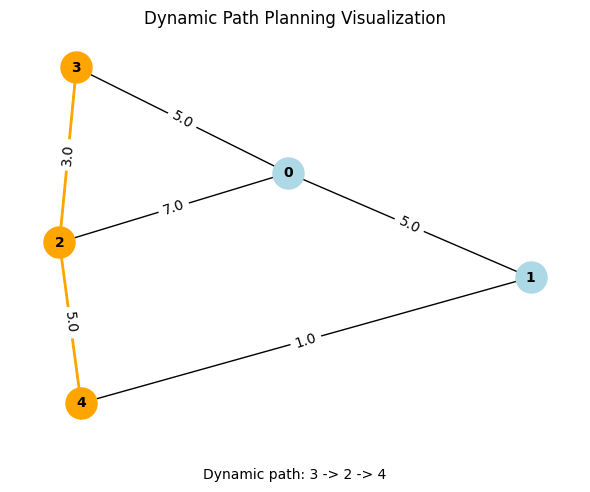

In [4]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_path(data: Data, path: List[int], use_pos: bool = True):
    G = nx.Graph()
    for i in range(data.edge_index.size(1)):
        u, v = data.edge_index[0, i].item(), data.edge_index[1, i].item()
        weight = data.edge_attr[i].item()
        G.add_edge(u, v, weight=weight)
    
    if use_pos and hasattr(data, 'pos'):
        pos = {i: data.pos[i] for i in range(len(data.pos))}
    else:
        pos = nx.spring_layout(G)
    
    plt.figure(figsize=(6, 5))
    
    # 绘制所有节点(除了路径中的节点)
    non_path_nodes = set(G.nodes()) - set(path)
    nx.draw_networkx_nodes(G, pos, nodelist=list(non_path_nodes), node_color='lightblue', node_size=500)
    
    # 绘制路径中的所有节点为红色
    nx.draw_networkx_nodes(G, pos, nodelist=path, node_color='orange', node_size=500)
    
    # 绘制边和标签
    nx.draw_networkx_edges(G, pos, width=1, arrows=False)
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
    
    # 绘制路径边
    path_edges = list(zip(path[:-1], path[1:]))
    nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='orange', width=2, arrows=True, arrowsize=20)
    
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    
    # 添加路径描述
    path_description = " -> ".join(map(str, path))
    plt.text(0.5, -0.1, f"Dynamic path: {path_description}", 
             horizontalalignment='center', 
             transform=plt.gca().transAxes)
    
    plt.title("Dynamic Path Planning Visualization")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# 使用示例:
visualize_path(data, result_path, use_pos=False)